In [1]:
import copt as cp
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse
from sklearn.utils.extmath import safe_sparse_dot
from copt.utils import safe_sparse_add
import copt.loss
import copt.penalty
from scipy.sparse import linalg as splinalg
from lights.model.regularizations import SparseGroupL1
from copt.loss import SquareLoss

import warnings
warnings.filterwarnings("ignore")

In [2]:
np.random.seed(0)

# .. generate some data ..
n_samples, n_features = 100, 12
groups = [np.arange(4 * i, 4 * i + 4) for i in range(3)]

# .. construct a ground truth vector in which ..
# .. group 4 and 5 are nonzero ..
ground_truth = np.zeros(n_features)
ground_truth[groups[0]] = np.array([1, 1, 0, 1])
ground_truth[groups[2]] = np.array([0.5, 0, 0.5, 0])

max_iter = 5000

np.random.seed(0)
A = sparse.rand(n_samples, n_features, density=0.2)
sigma = 1.0
b = A.dot(ground_truth) + sigma * np.random.randn(n_samples)

l_pen = 1e-05, eta = 0.9


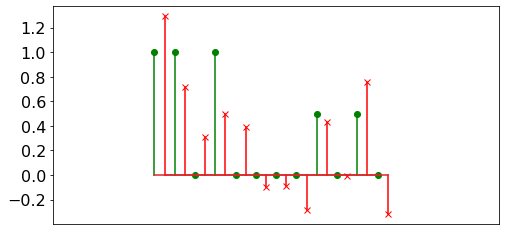

l_pen = 1e-05, eta = 0.6


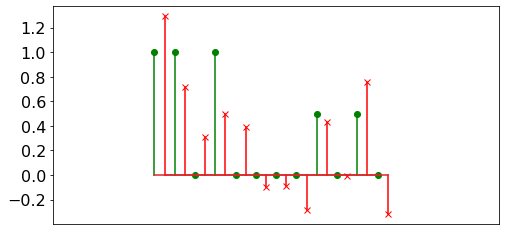

l_pen = 0.05, eta = 0.9


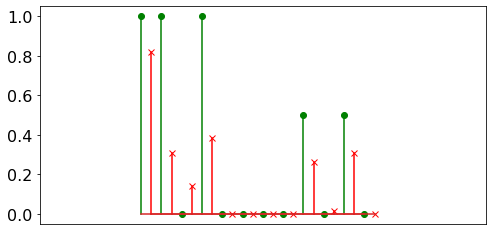

l_pen = 0.05, eta = 0.6


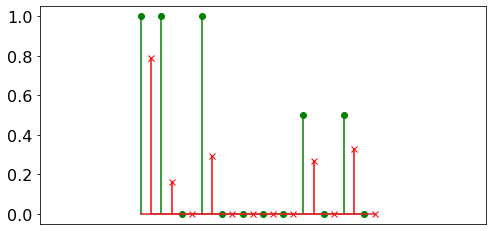

In [4]:
f = SquareLoss(A, b)
step_size = 1.0 / f.lipschitz

# .. run the solver for different values ..
# .. of the regularization parameter beta ..
all_reg = [(1e-5, 0.9), (1e-5, 0.6), (0.05, 0.9), (0.05, 0.6)]
all_trace_ls, all_trace_nols = [], []
out_img = []
for i, (l_pen, eta) in enumerate(all_reg):
    print("l_pen = %s, eta = %s" % (l_pen, eta))
    SGL1 = SparseGroupL1(l_pen, eta, groups)
    def loss(x):
        return f(x) + SGL1(x)

    x0 = np.zeros(n_features)
    pgd = cp.minimize_proximal_gradient(
        f.f_grad,
        x0,
        SGL1.prox,
        jac=True,
        max_iter=max_iter,
        tol=1e-20,
        trace_certificate=True,
    )
    out_img.append(pgd.x)
    
    param_true = ground_truth
    param_est = pgd.x
    fig = plt.figure(figsize=(8, 4))
    fontsize = 16
    ax = fig.add_subplot(111)
    ax.stem(np.arange(len(param_true)).tolist(), param_true, linefmt='g-', markerfmt='go')
    ax.stem((np.arange(len(param_est)) + .5).tolist(), param_est, linefmt='r-', markerfmt='rx')
    ax.set_xlim([-5, len(param_true) + 5])
    plt.yticks(fontsize=fontsize)
    plt.tick_params(axis='x', bottom=False, labelbottom=False)
    plt.show()